In [1]:
# add_project_root.py  – run first!
import sys, pathlib

here = pathlib.Path.cwd()
for p in [here] + list(here.parents):
    if (p / "src").is_dir():
        sys.path.insert(0, str(p / "src"))
        break
else:
    raise RuntimeError("Could not locate 'src' folder to add to PYTHONPATH")

In [2]:
from __future__ import annotations
import re
from typing import Sequence, List, Tuple, Optional
from math import log, exp, sqrt
import random
import numpy as np
import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
from torchvision.utils import make_grid

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_shape = (3, 32, 32)  # (C, H, W)

try:
    from layers.ResidualNetwork import ResidualNetwork
    from layers.RNVP             import RNVPBlock
    from layers.MERA             import MERABlock, RG_Flow
    from distributions import PriorDistribution
except ImportError:
    from residual_network import ResidualNetwork
    from rnvp             import RNVPBlock
    from mera             import MERABlock, RG_Flow
# ────────────────────────────────────────────────────────────────────────


def load_rgflow(
    checkpoint   : str,
    *,
    device       : str | torch.device = "cpu",
    kernel_size  : int  = 4,
    num_channels : int  = 3,
    apply_tanh   : bool = True,
    use_ckpt     : bool = True,
    strict       : bool = True,
) -> RG_Flow:
    ckpt  = torch.load(checkpoint, map_location=device)
    state = ckpt["model"] if isinstance(ckpt, dict) and "model" in ckpt else ckpt
    pat      = re.compile(r"^layers\.(\d+)\.network\.s_nets\.(\d+)\.")
    per_lvl  : dict[int, set[int]] = {}
    for k in state:
        m = pat.match(k)
        if m:
            lvl, blk = int(m.group(1)), int(m.group(2))
            per_lvl.setdefault(lvl, set()).add(blk)

    if not per_lvl:
        raise ValueError("Could not deduce RG‑Flow structure from checkpoint")

    depth            = max(per_lvl) + 1
    blocks_per_layer = [max(per_lvl[l]) + 1 for l in range(depth)]
    def _expand(depth: int, spec: int | Sequence[int]) -> List[int]:
        if isinstance(spec, int):
            return [int(spec)] * depth
        if not isinstance(spec, (list, tuple)) or len(spec) != depth:
            raise ValueError("blocks_per_layer shape mismatch")
        return [int(x) for x in spec]

    n_blocks = _expand(depth, blocks_per_layer)
    mera_layers = []
    for level, n in enumerate(n_blocks):
        s_nets = [ResidualNetwork() for _ in range(n)]
        t_nets = [ResidualNetwork() for _ in range(n)]
        rnvp   = RNVPBlock(
            kernel_size  = kernel_size,
            num_channels = num_channels,
            s_nets       = s_nets,
            t_nets       = t_nets,
            apply_tanh   = apply_tanh,
            use_ckpt     = use_ckpt,
        )
        mera_layers.append(
            MERABlock(
                m       = kernel_size,
                h       = level // 2,
                network = rnvp,
                shift   = (level % 2 == 1),
            )
        )

    model = RG_Flow(mera_layers).to(device)
    model.load_state_dict(state, strict=strict)
    model.eval()
    return model


In [3]:
flow_G = load_rgflow("../weights/gaussian.pth")
prior_G = PriorDistribution(dist_type='gaussian')

/Users/imangill/Desktop/DIS/project/new_repo/igf23/.venv/lib/python3.13/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


In [4]:
flow_L = load_rgflow("../weights/laplace.pth")
prior_L = PriorDistribution(dist_type='laplace')

In [5]:
def logit_transform(x, dequant=True, constraint=0.9, inverse=False):
    if inverse:
        logit_x = x
        pre_logit_scale = torch.tensor(log(constraint) - log(1 - constraint))
        ldj = (F.softplus(logit_x) + F.softplus(-logit_x) -
               F.softplus(-pre_logit_scale))
        ldj = ldj.view(ldj.shape[0], -1).sum(dim=1)
        x = 1 / (1 + torch.exp(-logit_x))
        x *= 2
        x -= 1
        x /= constraint
        x += 1
        x /= 2
        return x, ldj
    else:
        if dequant:
            noise = torch.rand_like(x)
            x = (x * 255 + noise) / 256
        x *= 2
        x -= 1
        x *= constraint
        x += 1
        x /= 2
        logit_x = torch.log(x) - torch.log(1 - x)
        pre_logit_scale = torch.tensor(log(constraint) - log(1 - constraint))
        ldj = (F.softplus(logit_x) + F.softplus(-logit_x) -
               F.softplus(-pre_logit_scale))
        ldj = ldj.view(ldj.shape[0], -1).sum(dim=1)
        return logit_x, ldj

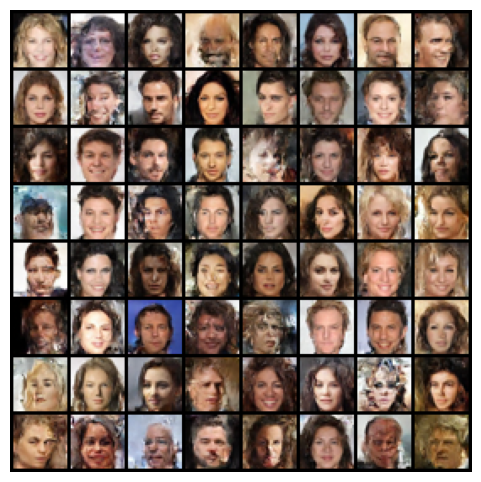

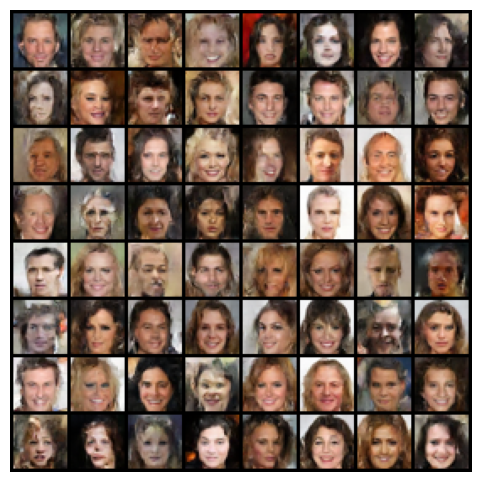

In [9]:
def sample_images(model, prior, n=64, T=0.9, size=(3,32,32)):
    model.eval()
    with torch.no_grad():
        z   = prior.sample((n, *size), temperature=T).to(DEVICE)     # temperature scaling
        x_l, _ = model.inverse(z)
        x,  _  = logit_transform(x_l, dequant=False, inverse=True)
        grid = make_grid(x.clamp(0,1).cpu(), nrow=int(sqrt(n)))
    plt.figure(figsize=(6,6)); plt.imshow(grid.permute(1,2,0)); plt.axis("off")

sample_images(flow_G, prior_G, T=0.75)
sample_images(flow_L, prior_L, T=0.75)

In [10]:
@torch.no_grad()
def compute_receptive_field(
    model: "RG_Flow",
    pixel_xy: Tuple[int, int],
    amp: float = 1.0,
) -> Optional[torch.Tensor]:
    """
    Returns a (H,W) heat‑map in [0,1] or *None* when the perturbation has no visible effect.
    """
    z0 = torch.zeros(1, *latent_shape, device=DEVICE)
    z1 = z0.clone()
    z1[:, :, pixel_xy[0], pixel_xy[1]] = amp

    x0, _ = model.inverse(z0)
    x1, _ = model.inverse(z1)
    x0, _ = logit_transform(x0, inverse=True, dequant=False)
    x1, _ = logit_transform(x1, inverse=True, dequant=False)

    heat = (x1 - x0).abs().sum(dim=1).squeeze(0)   # (H,W)
    maxv = heat.max().item()
    if maxv < 1e-8:      # no signal → skip
        return None
    return (heat / maxv).cpu()

def stride_for_level(h: int, m: int = 2) -> int:  # REDUCED from m=4 to m=2
    """Reduced stride growth to ensure more levels have valid pixels"""
    return max(1, m * (2 ** h))

def offset_for_level(h: int, m: int = 2, shifted: bool = False) -> int:  # REDUCED from m=4
    """Compute offset for shifted grids"""
    return (m // 2) * (2 ** h) if shifted else 0

def admissible_pixels(h: int, shifted: bool, max_stride: int = None) -> List[Tuple[int,int]]:

    stride = stride_for_level(h)
    if max_stride is not None:
        stride = min(stride, max_stride)
    
    off = offset_for_level(h, shifted=shifted)
    H = latent_shape[1]
    
    # Ensure we don't go outside bounds
    if off >= H:
        return []
    
    pixels = []
    for i in range(off, H, stride):
        for j in range(off, H, stride):
            pixels.append((i, j))
    
    return pixels

def plot_rf_grid(
    model: "RG_Flow",
    layer_cfg: List[Tuple[int,bool]],
    pix_per_layer: int = 3,
    amp: float = 1.0,
    adaptive_per_layer: bool = True,
    seed: int = 0,
    cmap: str = "inferno",
    max_stride: int = 16,  #Cap maximum stride
    debug_info: bool = False, 
):
    rng = np.random.default_rng(seed)
    
    # Filter to only show shift layers
    shift_layers = [(h, shift) for h, shift in layer_cfg if shift]
    
    if not shift_layers:
        print("ERROR: No shift layers found!")
        return
    
    if debug_info:
        print("Shift layer configuration analysis:")
        for i, (h, shift) in enumerate(shift_layers):
            candidates = admissible_pixels(h, shift, max_stride=max_stride)
            stride = min(stride_for_level(h), max_stride or float('inf'))
            print(f"  Row {i}: Layer {h} (shift) - stride={stride}, {len(candidates)} pixels available")

    # Compute actual available pixels per layer
    available_pixels = [
        len(admissible_pixels(h, s, max_stride=max_stride)) 
        for h, s in shift_layers
    ]
    
    if adaptive_per_layer:
        col_counts = [min(pix_per_layer, avail) for avail in available_pixels]
        n_cols = max(col_counts) if col_counts else pix_per_layer
    else:
        col_counts = [min(pix_per_layer, avail) for avail in available_pixels]
        n_cols = pix_per_layer

    # Filter out layers with no available pixels
    valid_layers = [(i, cfg) for i, (cfg, count) in enumerate(zip(shift_layers, col_counts)) if count > 0]
    
    if not valid_layers:
        print("ERROR: No shift layers have available pixels!")
        return
    
    n_rows = len(valid_layers)
    fig, axes = plt.subplots(
        n_rows, n_cols, figsize=(n_cols*2.4, n_rows*2.4), squeeze=False
    )

    for plot_row, (orig_row, (h, shift)) in enumerate(valid_layers):
        candidates = admissible_pixels(h, shift, max_stride=max_stride)
        n_this_row = col_counts[orig_row]
        rng.shuffle(candidates)
        
        for c in range(n_cols):
            ax = axes[plot_row, c]
            if c >= n_this_row:
                ax.axis("off")
                continue

            i, j = candidates[c]
            heat = compute_receptive_field(model, (i, j), amp=amp)
            if heat is None:
                ax.text(0.5, 0.5, 'No signal', ha='center', va='center', 
                       transform=ax.transAxes, fontsize=8)
                ax.set_xticks([]); ax.set_yticks([])
                continue

            im = ax.imshow(heat, cmap=cmap, origin="upper")
            ax.add_patch(Circle((j, i), radius=1.0, edgecolor="white",
                                facecolor="none", linewidth=1.2))
            ax.set_title(f"({i},{j})", fontsize=8)
            ax.set_xticks([]); ax.set_yticks([])

        # Row label
        stride = min(stride_for_level(h), max_stride or float('inf'))
        axes[plot_row, -1].text(
            1.05, 0.5,
            r"$h=$" + str(h) ,
            transform=axes[plot_row, -1].transAxes,
            rotation=-90, va='center', ha='left', fontsize=18
        )

    plt.tight_layout()
    plt.show()

def layer_configuration(model: "RG_Flow", reverse: bool = True, shift_only: bool = True, verbose: bool = False) -> List[Tuple[int,bool]]:
    """
    Returns [(h, shift), …] from the model's MERA blocks
    Default to show pass through disentangler and decimator
    """
    config = [(blk.h, blk.shift) for blk in model.layers]
    
    if shift_only:
        config = [(h, shift) for h, shift in config if shift]
        if verbose:
            print(f"Model has {len(config)} SHIFT layers:")
    elif verbose:
        print(f"Model has {len(config)} total layers:")
    
    if reverse:
        config = config[::-1]  # coarsest → finest
    
    if verbose:
        for i, (h, shift) in enumerate(config):
            shift_text = "shift" if shift else "no-shift"
            print(f"  Layer {i}: h={h}, {shift_text}")
    
    return config

def diagnose_model_layers(model: "RG_Flow", max_stride: int = 16, shift_only: bool = True):
    print("=== MODEL SHIFT LAYER DIAGNOSIS ===")
    
    # Get layer config
    all_layers = [(blk.h, blk.shift) for blk in model.layers]
    
    if shift_only:
        shift_layers = [(h, shift) for h, shift in all_layers if shift]
        print(f"\nFound {len(shift_layers)} shift layers out of {len(all_layers)} total layers")
        
        if not shift_layers:
            print("WARNING: No shift layers found in the model!")
            return
        
        configs_to_analyze = [("Shift layers (coarsest→finest)", shift_layers[::-1]),
                             ("Shift layers (finest→coarsest)", shift_layers)]
    else:
        configs_to_analyze = [("All layers (coarsest→finest)", all_layers[::-1]),
                             ("All layers (finest→coarsest)", all_layers)]
    
    print(f"\nPixel availability analysis (32x32 latent, max_stride={max_stride}):")
    for order_name, config in configs_to_analyze:
        print(f"\n{order_name}:")
        total_pixels = 0
        for i, (h, shift) in enumerate(config):
            pixels = admissible_pixels(h, shift, max_stride=max_stride)
            stride = min(stride_for_level(h), max_stride)
            shift_text = "shift" if shift else "no-shift"
            print(f"  Position {i}: h={h}, {shift_text} → stride={stride}, {len(pixels)} pixels")
            total_pixels += len(pixels)
        print(f"  Total pixels across all layers: {total_pixels}")

def demo_receptive_fields(flow, seed: int = 0, debug: bool = False, shift_only: bool = True):

    if debug:
        diagnose_model_layers(flow, max_stride=16, shift_only=shift_only)
    
    layer_cfg = layer_configuration(flow, reverse=True, shift_only=shift_only)
    
    if not layer_cfg:
        print("No layers to display!")
        return
    
    plot_rf_grid(
        model=flow,
        layer_cfg=layer_cfg,
        pix_per_layer=3,
        amp=1.0,
        seed=seed,
        adaptive_per_layer=True,
        max_stride=16,  # Prevent overly large strides
        debug_info=False
    )


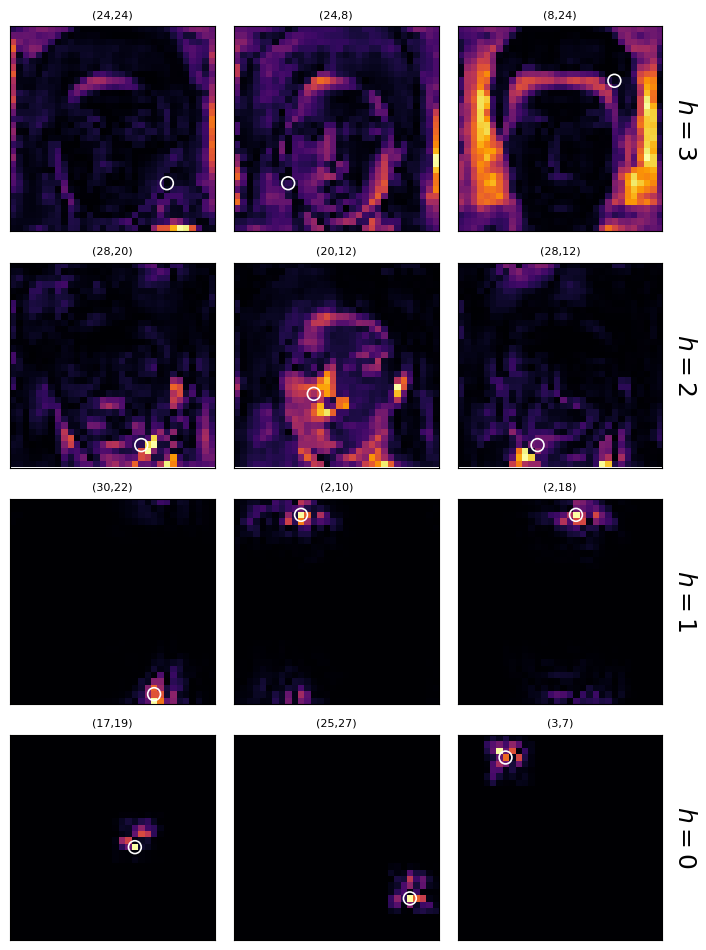

In [11]:
# Usage example for Gaussian prior
demo_receptive_fields(flow_G, seed=42)

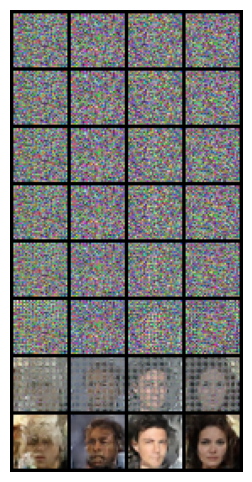

In [12]:
def progressive_generate_vert(model, prior, n=4, size=(3,32,32), T=0.65, seed=42):

    model.eval()
    z = prior.sample((n, *size), temperature=T).to(DEVICE)
    imgs = []
    x, _ = z, torch.zeros(n, device=DEVICE)

    # Go **down** the hierarchy and snapshot after every MERA block
    for blk in reversed(model.layers):
        x, _ = blk.inverse(x)          # inverse RG step (generation)
        vis, _ = logit_transform(x, dequant=False, inverse=True)
        imgs.append(vis.clamp(0,1).cpu())

    # plot row‑wise
    grid = make_grid(torch.cat(imgs,0), nrow=n)
    plt.figure(figsize=(12,6)); plt.imshow(grid.permute(1,2,0)); plt.axis("off")
    model.train()

progressive_generate_vert(flow_G, prior_G)

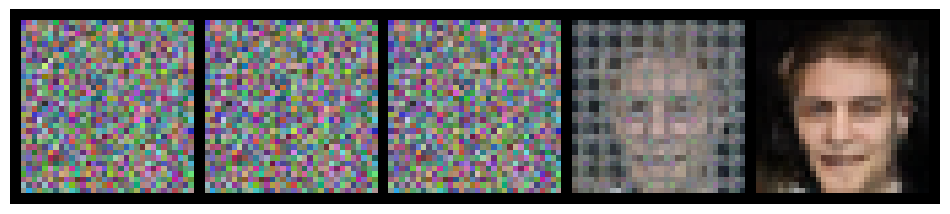

In [13]:
def progressive_generate(model,
                         prior,
                         n: int = 4,
                         size: tuple[int, int, int] = (3, 32, 32),
                         T: float = 0.8,
                         seed: int = 42,
                         shift_only: bool = True):
    """
    Display a grid whose columns are successive snapshots (time-steps)
    and whose rows are the n parallel samples.

    The last column is still the fully generated image.
    """
    # ---- RNG for reproducibility ------------------------------------------
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark     = False
    # -----------------------------------------------------------------------

    model.eval()
    with torch.no_grad():
        z   = prior.sample((n, *size), temperature=T).to(DEVICE)
        x,_ = z, torch.zeros(n, device=DEVICE)

        snapshots = []                                      # list of (n,3,H,W)
        for blk in reversed(model.layers):
            x,_ = blk.inverse(x)
            if shift_only and not getattr(blk, "shift", False):
                continue
            vis,_ = logit_transform(x, dequant=False, inverse=True)
            snapshots.append(vis.clamp(0, 1).cpu())

        # ensure the final image is included
        vis_final,_ = logit_transform(x, dequant=False, inverse=True)
        vis_final   = vis_final.clamp(0, 1).cpu()
        if not snapshots or not torch.equal(snapshots[-1], vis_final):
            snapshots.append(vis_final)

    if not snapshots:
        raise RuntimeError("No snapshots collected — nothing to plot.")

    # ---- rearrange so time runs along x-axis -------------------------------
    # snapshots: list length M, each tensor shape (n,3,H,W)
    stack      = torch.stack(snapshots)            # (M, n, 3, H, W)
    tiles      = stack.permute(1, 0, 2, 3, 4)      # (n, M, 3, H, W)
    tiles      = tiles.reshape(-1, *tiles.shape[2:])  # (n*M, 3, H, W)
    grid       = make_grid(tiles, nrow=len(snapshots))

    plt.figure(figsize=(12, 6))
    plt.imshow(grid.permute(1, 2, 0))              # (H, W, C)
    plt.axis("off")


progressive_generate(flow_G, prior_G, T=0.65, seed=4, n=1)